In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

#plt.style.use('fivethirtyeight')

# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

### Output

In [3]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [4]:
train_fraction = 0.8

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]

In [5]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [6]:
epochs = 50000
# X_train = X_train.todense()
# X_test = X_test.todense()

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train,'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=50,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test,'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [7]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=0.1,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f05ade3b5c0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/test'}


# Training



In [8]:
tf.set_random_seed(42)

    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",#loss
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=3000)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../models/test/model.ckpt.
INFO:tensorflow:loss = 1.5805475, step = 0
INFO:tensorflow:global_step/sec: 260.821
INFO:tensorflow:loss = 1.9809855, step = 100 (0.386 sec)
INFO:tensorflow:global_step/sec: 296.58
INFO:tensorflow:loss = 1.4797722, step = 200 (0.337 sec)
INFO:tensorflow:global_step/sec: 296.706
INFO:tensorflow:loss = 1.6397889, step = 300 (0.335 sec)
INFO:tensorflow:global_step/sec: 300.037
INFO:tensorflow:loss = 2.2143161, step = 400 (0.334 sec)
INFO:tensorflow:Saving checkpoints for 501 into ../models/test/mo

INFO:tensorflow:loss = 0.20286478, step = 4700 (0.343 sec)
INFO:tensorflow:global_step/sec: 300.689
INFO:tensorflow:loss = 0.6182333, step = 4800 (0.334 sec)
INFO:tensorflow:global_step/sec: 310.517
INFO:tensorflow:loss = 0.57646775, step = 4900 (0.321 sec)
INFO:tensorflow:Saving checkpoints for 5001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 255.251
INFO:tensorflow:Starting evaluation at 2018-10-05-02:15:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-5001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-05-02:15:11
INFO:tensorflow:Saving dict for global step 5001: accuracy = 0.83687645, global_step = 5001, loss = 0.48210406
INFO:tensorflow:Validation (step 5000): loss = 0.48210406, accuracy = 0.83687645, global_step = 5001
INFO:tensorflow:loss = 0.2337471, step = 5000 (1.855 sec)
INFO:tensorflow:global_step/sec: 55.9386
INF

INFO:tensorflow:global_step/sec: 297.547
INFO:tensorflow:loss = 0.21017547, step = 9800 (0.336 sec)
INFO:tensorflow:global_step/sec: 300.449
INFO:tensorflow:loss = 1.1161757, step = 9900 (0.335 sec)
INFO:tensorflow:Saving checkpoints for 10001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 243.758
INFO:tensorflow:loss = 0.20203006, step = 10000 (0.408 sec)
INFO:tensorflow:global_step/sec: 305.557
INFO:tensorflow:loss = 0.5332068, step = 10100 (0.329 sec)
INFO:tensorflow:global_step/sec: 296.258
INFO:tensorflow:loss = 0.36662304, step = 10200 (0.336 sec)
INFO:tensorflow:global_step/sec: 298.968
INFO:tensorflow:loss = 0.3488349, step = 10300 (0.334 sec)
INFO:tensorflow:global_step/sec: 296.982
INFO:tensorflow:loss = 0.36984578, step = 10400 (0.337 sec)
INFO:tensorflow:Saving checkpoints for 10501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 252.468
INFO:tensorflow:Starting evaluation at 2018-10-05-02:15:35
INFO:tensorflow:Graph was finalized.
INFO:te

INFO:tensorflow:global_step/sec: 310.168
INFO:tensorflow:loss = 0.6683876, step = 14800 (0.320 sec)
INFO:tensorflow:global_step/sec: 305.333
INFO:tensorflow:loss = 0.41148323, step = 14900 (0.328 sec)
INFO:tensorflow:Saving checkpoints for 15001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 248.03
INFO:tensorflow:loss = 0.18543746, step = 15000 (0.403 sec)
INFO:tensorflow:global_step/sec: 302.032
INFO:tensorflow:loss = 0.32433522, step = 15100 (0.334 sec)
INFO:tensorflow:global_step/sec: 307.331
INFO:tensorflow:loss = 0.18403664, step = 15200 (0.323 sec)
INFO:tensorflow:global_step/sec: 298.377
INFO:tensorflow:loss = 0.48662242, step = 15300 (0.335 sec)
INFO:tensorflow:global_step/sec: 302.884
INFO:tensorflow:loss = 0.56885344, step = 15400 (0.332 sec)
INFO:tensorflow:Saving checkpoints for 15501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 259.212
INFO:tensorflow:loss = 1.3827573, step = 15500 (0.384 sec)
INFO:tensorflow:global_step/sec: 309.343


INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-05-02:16:19
INFO:tensorflow:Saving dict for global step 20001: accuracy = 0.8427768, global_step = 20001, loss = 0.4459306
INFO:tensorflow:Validation (step 20000): loss = 0.4459306, accuracy = 0.8427768, global_step = 20001
INFO:tensorflow:loss = 0.2686424, step = 20000 (1.936 sec)
INFO:tensorflow:global_step/sec: 53.4815
INFO:tensorflow:loss = 0.5087921, step = 20100 (0.329 sec)
INFO:tensorflow:global_step/sec: 288.909
INFO:tensorflow:loss = 0.11109329, step = 20200 (0.346 sec)
INFO:tensorflow:global_step/sec: 302.991
INFO:tensorflow:loss = 0.424581, step = 20300 (0.330 sec)
INFO:tensorflow:global_step/sec: 306.472
INFO:tensorflow:loss = 0.22405475, step = 20400 (0.327 sec)
INFO:tensorflow:Saving checkpoints for 20501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 253.626
INFO:tensorflow:loss = 0.6371736, step = 20500 (0.396 sec)
INFO:tensorflow:global_step/sec: 301.212
INFO:te

# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-21501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


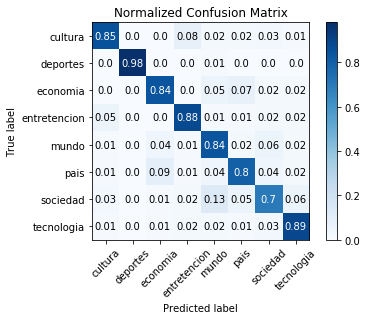

## Accuracy in test: 87.23515618457415 

In [9]:
#X_test = X_test.todense()

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test)}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

In [10]:
pred_test

<generator object DNNClassifier.predict_classes.<locals>.<genexpr> at 0x7f05ae52ef68>